In [1]:
import intake
import healpy as hp
import cmocean
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

import easygems.healpix as egh
import seaborn as sns

In [2]:
Lv = 2.5e6
cp = 1004.
Rd = 287.05
grav = 9.81

data_path = '/home/WUR/janss254/orcestra/data'

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
era5 = cat.HERA5(time="P1D").to_dask()
era5

/home/WUR/janss254/miniconda3/envs/orcestra_env/lib/python3.10/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 2TB
Dimensions:    (time: 4991, cell: 196608, level: 29, crs: 1)
Coordinates:
  * crs        (crs) float64 8B nan
    latitude   (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
  * level      (level) int64 232B 50 70 100 125 150 175 ... 900 925 950 975 1000
    longitude  (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
  * time       (time) datetime64[ns] 40kB 2010-01-01T12:00:00 ... 2023-08-31T...
Dimensions without coordinates: cell
Data variables: (12/72)
    100u       (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    100v       (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    10u        (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    10v        (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    2d         (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    2t         (time, cell) float32 4GB dask.array<chunksize=(24, 4096), meta=np.ndarray>
    ...         ...
    isor       (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    lsm        (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    sdfor      (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    sdor       (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    slor       (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
    z_sfc      (cell) float32 786kB dask.array<chunksize=(196608,), meta=np.ndarray>
Attributes:
    title:           HERA5 - HEALPixelation of ERA5
    description:     Selected variables from ERA5, restructured and saved on ...
    source:          Post-processed dataset based on the ERA5 mirror located ...
    creator:         Lukas Kluft
    institution:     Max Planck Institute for Meteorology
    contact:         lukas.kluft@mpimet.mpg.de
    acknowledgment:  Contains modified Copernicus Climate Change Service info...

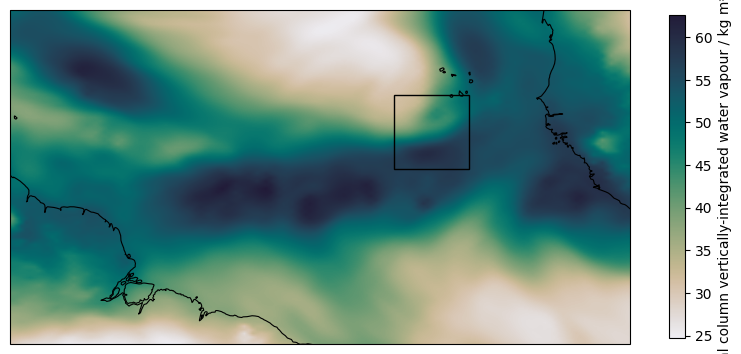

In [3]:
# Selecting the orcestra region and time
# (from https://orcestra-campaign.org/hera5.html)
# [W, E, S, N]
import matplotlib.patches as patches

extent_orcestra = [-60, -10, -5, 20]
extent_orcestra_cabo = [-29, -23, 9, 15] # Cabo => Start looking here

is_orcestra = egh.isel_extent(era5, extent_orcestra)
var = era5["tcwv"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent(extent_orcestra)
ax.coastlines(lw=0.8)
im = egh.healpix_show(
    var.sel(time="2020-08-01").values,
    method="linear",
    cmap="cmo.rain",
#     vmin=0,
)
fig.colorbar(im, label=f"{var.long_name} / {var.units}", shrink=0.7)

rect = patches.Rectangle((extent_orcestra_cabo[0], extent_orcestra_cabo[2]), # origin
                         extent_orcestra_cabo[1] - extent_orcestra_cabo[0], # width
                         extent_orcestra_cabo[3] - extent_orcestra_cabo[2], # heigh
                         linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)
plt.savefig(data_path+'/figures/analysis-domain.png', dpi=300, bbox_inches='tight')

In [4]:
# Try to make profiles of u, v, w, theta_l, q_t in this area, for the orcestra time (summer)
variables = ['z', 'q', 'r', 'clwc', 't', 'u', 'v', 'w', 'sst', 'sp']
extent_orcestra = [-29, -23, 9, 15] # Cabo => Start looking here
months_orcestra = [7, 8, 9]

is_orcestra = egh.isel_extent(era5, extent_orcestra)
era5_env = era5[variables].sel(cell=is_orcestra).isel(time=era5.time.dt.month.isin(months_orcestra))

era5_env['height'] = era5_env['z'] / grav # geopotential => height
era5_env['pres'] = era5_env['level'] * 100 # hPa => Pa

# Conversions
era5_env['theta_l']  = (1e5/era5_env['pres'])**(2/7)*(era5_env['t'] - Lv/cp*era5_env['clwc']) # FIXME Ignores rain, ice, snow
era5_env['theta_l_s'] = (1e5/era5_env['pres'])**(2/7)*era5_env['sst'] # Assuming qts = qtsat and thus qls = 0.
era5_env['rho'] = era5_env['pres']/Rd/era5_env['t'] # Dry approximation, is that okay?
era5_env['ws'] = -era5_env['w']/era5_env['rho']/grav # w = -\omega/(g\rho)
era5_env['U'] = np.sqrt(era5_env['u']**2 + era5_env['v']**2)
era5_env['qs'] = era5_env['q'] / (era5_env['r'] / 100)

In [5]:
# Make mean vertical profiles

# Let's assume we can interchange the time/space mean pressure levels with a uniform horizontal coordinate
# This isn't entirely accurate (see below, z varies around a pressure level with std ~10-50 m around 10 km)
# But that's even below the grid spacing we'll use, so I'll take it for now
# era5_env['height'].mean(['cell', 'time']).plot(y='level')
# plt.show()
# era5_env['height'].mean('cell').std('time').plot(y='level')
era5_env['zm'] = era5_env['height'].mean(['cell', 'time'])
era5_env = era5_env.set_coords(['zm']).swap_dims({'level':'zm'})

In [6]:
# Compute and download locally for future analysis (takes a few min)
download = False
if download:
    era5_env.to_netcdf(data_path+'/era5_env.nc', mode='w')
else:
    era5_env = xr.open_dataset(data_path+'/era5_env.nc')
era5_env_mn = era5_env.mean(dim=['cell','time'])
era5_env_25 = era5_env.quantile(0.25, dim=['cell','time'])
era5_env_75 = era5_env.quantile(0.75, dim=['cell','time'])

if download:
    era5_env_mn.to_netcdf(data_path+'/era5_env_mn.nc', mode='w')

In [8]:
# Interpolate the data onto a lat/lon grid
from utils import interpolate_to_latlon

era5_env_ll = interpolate_to_latlon(era5_env)